<a href="https://colab.research.google.com/github/RobSpiewakowski/Public_repository/blob/main/Projekt_ML_algorytm_rekomenduj%C4%85cy_zamieszczenie_oferty_na_platformie_handlowej_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Opis projektu:

Celem projektu jest zbudowanie i wdrożenie narzędzia, które na podstawie wyników z nauki zdecyduje, czy zarekomendować produkt do wystawienia na platformie handlowej. Rozwiązanie ma pomóc sprzedawcom w modelu Dropshipping ocenić, czy ich oferta nadaje się do wystawienia.

Musimy w tym celu stworzyć i wytrenować model, który potem posłuży do zbudowania aplikacji klienckiej.

W ramach aplikacji będzie możliwy zadanie w input: pojedynczej obserwacji lub całej serii, np, w postaci pliku csv lub xlsx.

Na razie skupimy się na pojedynczym inpucie, w postaci informacji:
* Jaki to produkt,
* Koszt zakupu u dostawcy (należy mieć na uwadze koszt pakowania, za wysyłkę płaci klient końcowy),
* Stan magazynowy u dostawcy,
* Cena minimalna sprzedaży na platformie (w ulepszonej wersji będzie pobierana przez API portalu),
* Cena maksymalna sprzedaży na platformie (w ulepszonej wersji będzie pobierana przez API portalu),
* Mediana cen sprzedaży na platformie (w ulepszonej wersji będzie pobierana przez API portalu).

Aplikacja wypluje output w jednej z następujących postaci:
* "Wystaw ten produkt" -> Jeśli model zarekomenduje wystawienie produktu,
* "Nie wystawiaj tego produktu" -> Jeśli model zarekomenduje przeiwnie.

Aplikacja dokona predykcji na podstawie wyuczonego wcześniej modelu. Model bedzie brał pod uwagę 4 zmienne:
* Koszt zakupu u dostawcy -> czy nie jest on zbyt wysoki,
* Liczba ofert tego produktu -> Decyduje o popularności produktu lub znajdowaniu się w niszy,
* Spodziewana marża procentowa -> Im wyższa tym lepiej,
* Amplituda cen -> W jaki sposób może wpłynąć na decyzję, jeszcze nie wiemy.

# Prerpocessing danych:

W tej sekcji przygotujemy dane do uczenia maszynowego. Zidentyfikujemy anomalie i przeprowadzimy standartzację.

In [2]:
# Inne biblioteki:
import pandas as pd
import numpy as np
import time
import random
import plotly.express as px
import seaborn as sns

# Biblioteka sklearn:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifier
from sklearn import pipeline
from sklearn import model_selection
from pprint import pprint

In [3]:
# Wczytaj dane do modelu:
ML_data = pd.read_excel('/content/Dane_do_ML.xlsx').drop(columns = 'Unnamed: 0')

# Dla ułatwienia pracy komputerowi, zamieniamy wartości w kolumnie 'Wystawić?':
## 'Tak' zmienia się w 1,
## 'Nie' zmienia się w 0
ML_data['Wystawić?'] = ML_data['Wystawić?'].replace('Nie', 0)
ML_data['Wystawić?'] = ML_data['Wystawić?'].replace('Tak', 1)
ML_data

,Koszt zakupu u dostawcy,Stan magazynowy dostawcy,Liczba ofert sprzedaży,Spodziewana marża %,Spodziewana marża zł,Amplituda cen ofert sprzedaży,Wystawić?
0,180.71,68,34,57.32,103.582972,186.87,1
1,30.71,76,320,-31.63,-9.713573,31.75,0
2,94.90,31,169,-61.84,-58.686160,98.14,0
3,22.79,10,24,-23.79,-5.421741,23.57,0
4,96.14,98,261,-78.66,-75.623724,99.42,0
...,...,...,...,...,...,...,...
19816,165.27,76,326,-39.36,-65.050272,170.90,0
19817,137.77,4,365,-89.54,-123.359258,142.46,0
19818,93.93,39,473,-44.08,-41.404344,97.14,0
19819,38.22,76,337,36.97,14.129934,39.52,0


In [4]:
# Liczebność wartości zmiennej objasnianej:
ML_data['Wystawić?'].value_counts()

0    14942
1     4879
Name: Wystawić?, dtype: int64

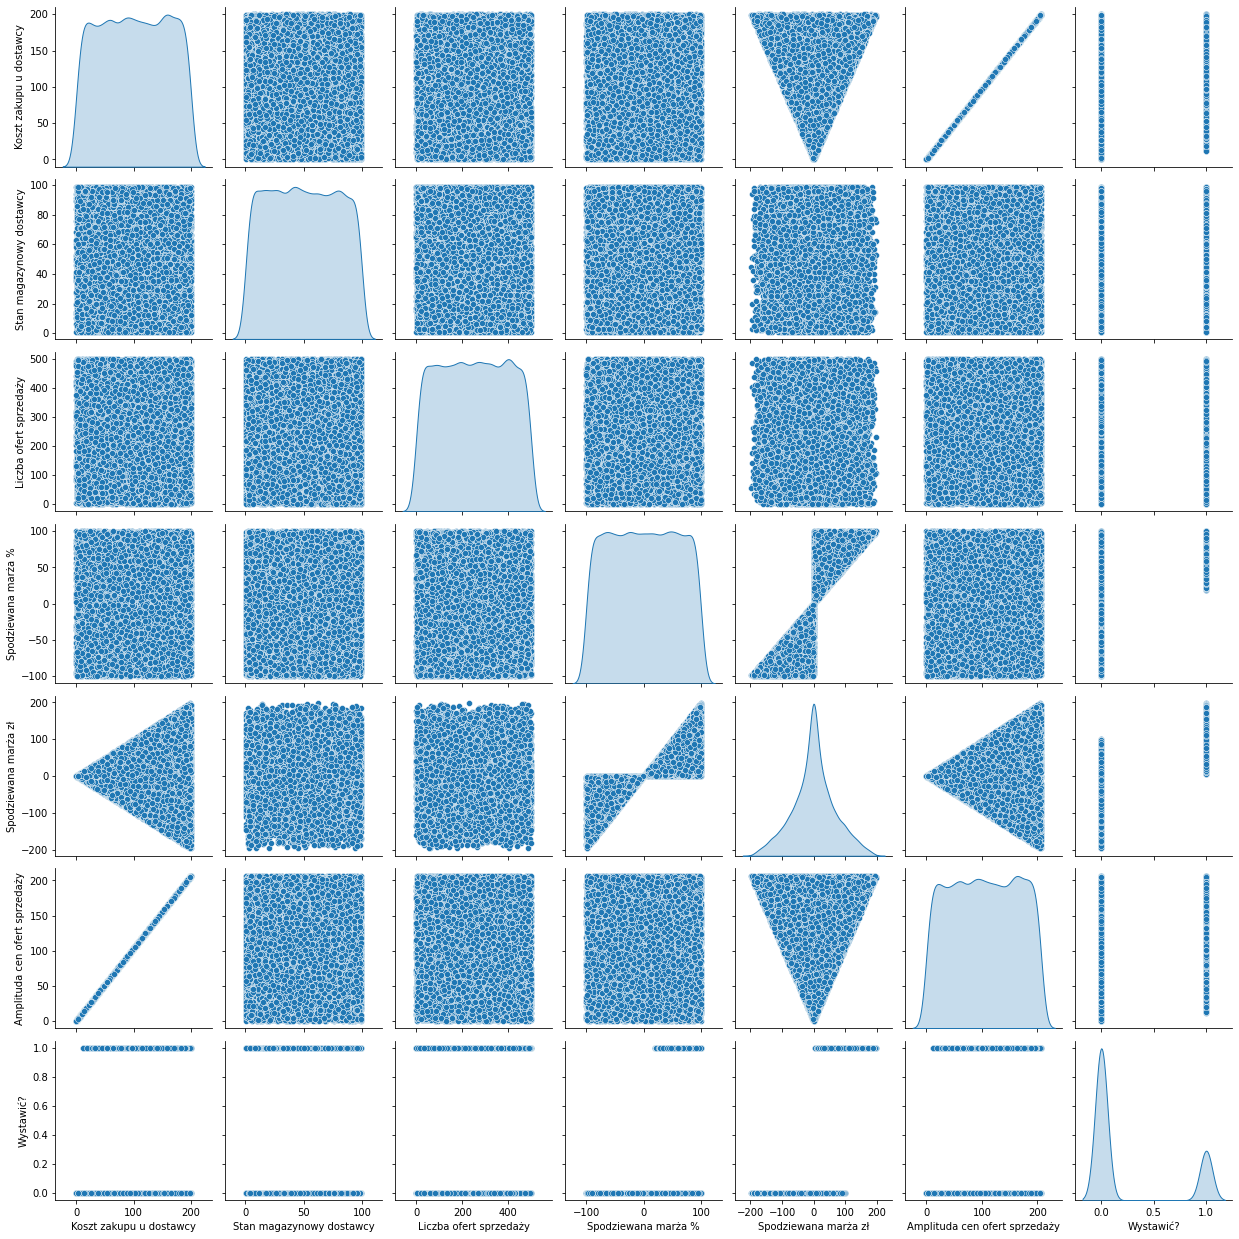

In [5]:
# Rozkład wartości zmiennych:
sns.pairplot(ML_data, diag_kind = 'kde')

In [6]:
# Korelacja między zmiennymi:
ML_data.corr().style.background_gradient(cmap = 'RdYlGn_r')

,Koszt zakupu u dostawcy,Stan magazynowy dostawcy,Liczba ofert sprzedaży,Spodziewana marża %,Spodziewana marża zł,Amplituda cen ofert sprzedaży,Wystawić?
Koszt zakupu u dostawcy,1.000000,-0.010489,-0.014577,0.003951,0.000630,1.000000,0.266562
Stan magazynowy dostawcy,-0.010489,1.000000,-0.007720,0.000963,-0.001436,-0.010489,0.143905
Liczba ofert sprzedaży,-0.014577,-0.007720,1.000000,-0.001754,0.005858,-0.014576,-0.017032
Spodziewana marża %,0.003951,0.000963,-0.001754,1.000000,0.865222,0.003951,0.651514
Spodziewana marża zł,0.000630,-0.001436,0.005858,0.865222,1.000000,0.000630,0.701943
Amplituda cen ofert sprzedaży,1.000000,-0.010489,-0.014576,0.003951,0.000630,1.000000,0.266562
Wystawić?,0.266562,0.143905,-0.017032,0.651514,0.701943,0.266562,1.000000


In [7]:
# Między zmiennymi 'Koszt zakupu u dostawcy' oraz 'Amplituda cen ofert sprzedaży' występuje bardzo silna korelacja.
# W modelu uczenia maszynowego, można więc wyrzucić jedną z tych zmiennych.
# Wyleci 'Amplituda cen'. Jednak dla danych w INPUT pozostanie, gdyż to na jej podstawie obliczana jest marża.
ML_data = ML_data.drop(columns = 'Amplituda cen ofert sprzedaży')
ML_data

,Koszt zakupu u dostawcy,Stan magazynowy dostawcy,Liczba ofert sprzedaży,Spodziewana marża %,Spodziewana marża zł,Wystawić?
0,180.71,68,34,57.32,103.582972,1
1,30.71,76,320,-31.63,-9.713573,0
2,94.90,31,169,-61.84,-58.686160,0
3,22.79,10,24,-23.79,-5.421741,0
4,96.14,98,261,-78.66,-75.623724,0
...,...,...,...,...,...,...
19816,165.27,76,326,-39.36,-65.050272,0
19817,137.77,4,365,-89.54,-123.359258,0
19818,93.93,39,473,-44.08,-41.404344,0
19819,38.22,76,337,36.97,14.129934,0


In [8]:
# Wykrywanie wartości odstających - metodą IQR
def IQR_outliers(a, b, c):
  Q1, Q3 = np.percentile(a, [b, c])
  IQR = Q3 - Q1

  upper_limit = Q3 + (1.5 * IQR)
  lower_limit = Q1 - (1.5 * IQR)
  print('Upper limit = ', upper_limit, '\n', 'Lower limit = ', lower_limit)

  indexes = np.where((a > upper_limit) | (a < lower_limit))
  b = np.full(shape = a.shape[0], fill_value = 1)
  b[indexes] = -1

  return b

In [9]:
variables = ML_data.columns.tolist()
variables.remove('Wystawić?')

for i in range(len(variables)):
  ML_data['IQR_flag'] = IQR_outliers(ML_data[variables[i]], 25, 75)

  plot = px.scatter(ML_data, y = variables[i], color = 'IQR_flag')
  plot.show()

  ML_data = ML_data[ML_data['IQR_flag'] != -1]
  print(ML_data.shape[0])

ML_data = ML_data.drop(columns = 'IQR_flag')

Upper limit =  301.78499999999997 
 Lower limit =  -99.61499999999998


19821
Upper limit =  150.0 
 Lower limit =  -50.0


19821
Upper limit =  746.0 
 Lower limit =  -246.0


19821
Upper limit =  199.51999999999998 
 Lower limit =  -199.92


19821
Upper limit =  150.285774 
 Lower limit =  -150.07744200000002


19157


# Dobór modelu uczenia maszynowego, zastosowanie go i ewaluacja. Wybór modelu optymalnego (Sklearn):

Jako, że spodziewanym outputem jest 'Tak' lub 'Nie', to użyjemy modeli klastyfikatorów binarnych:
* LogisticRegression(),
* KNeighboursClassifier(),
* RandomForestClassifier(),
* SGDClessifier(),
* RidgeClassifier().

In [10]:
# Identyfikacja zmiennych objasniających i zmiennej objaśnianej:
X = ML_data.drop(columns = 'Wystawić?').values
y = ML_data['Wystawić?']

# Podział danych na zbiór uczący i testowy:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size = 0.1, random_state = 2000)

# Rozmiary zbiorów:
print('X_train: ', X_train.shape, ', X_test: ', X_test.shape, '\n y_train: ', y_train.shape, 'y_test: ', y_test.shape)

X_train:  (17241, 5) , X_test:  (1916, 5) 
 y_train:  (17241,) y_test:  (1916,)


In [11]:
# Użycie modeli uczenia maszynowego do predykcji:
ML_models = {'Logistic regression': LogisticRegression(),
             'K neighbours': KNeighborsClassifier(),
             'Random forest': RandomForestClassifier(),
             'SGD': SGDClassifier(),
             'Ridge classifier': RidgeClassifier()}

# Prediction with all models with default parameters:
for key in ML_models:
  model = ML_models[key]
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  print('Used model: ', model)
  acc = accuracy_score(y_test, y_pred)
  print(f'Accuracy score is = {round(acc, 4)}')
  print(confusion_matrix(y_test, y_pred))
  print('-----------------------------------------------------------------------------------------------------------------')

Used model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy score is = 0.9629
[[1431   33]
 [  38  414]]
-----------------------------------------------------------------------------------------------------------------
Used model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Accuracy score is = 0.9796
[[1446   18]
 [  21  431]]
-----------------------------------------------------------------------------------------------------------------
Used model:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini'

In [12]:
# Najlepszym modelem okazał się być RandomForestClassifier(), którego dokładność przekroczyła 99 %. To jest zajebisty wynik i,
# w związku z tym, użyjemy tego modelu do predykcji

# Predykcja na najlepszym modelu:
best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.9973903966597077


array([[1462,    2],
       [   3,  449]])

In [15]:
wynik = pd.DataFrame(X_test, columns = ['Koszt zakupu u dostawcy', 'Stan magazynowy u dostawcy', 'Liczba ofert sprzedaży', 'Spodziewana marża %', 'Spodziewana marża zł'])
wynik['rekomendacja modelu'] = y_pred

px.scatter_3d(wynik, x = 'Koszt zakupu u dostawcy', y = 'Liczba ofert sprzedaży', z = 'Spodziewana marża %', color = 'rekomendacja modelu')

# Użycie modelu na danych zadanych przez użytkownika (Sklearn):

In [20]:
# Spróbujmy coś przewidzieć na parametrach zadanych przez użytkownika:

x1 = float(input('Koszt zakupu u dostawcy: '))
x2 = int(input('Stan magazynowy produktu u dostawcy: '))
x3 = int(input('Liczba ofert na platformie: '))
a1 = float(input('Cena najtańszej oferty: '))
a2 = float(input('Cena najdroższej oferty: '))
a3 = float(input('Mediana cen - cena oferty będącej dokładnie na środku: '))
x4 = 100 * (a3 - x1) / a3
x5 = a3 - x1

parametry = np.array([x1, x2, x3, x4, x5]).reshape(1, -1)

# Predykcja:
odpowiedź = best_model.predict(parametry)
if odpowiedź[0] == 0:
  print('Rekomendacja dla tego produktu to: Nie wystawiaj')
else:
  print('Rekomendacja dla tego produktu to: Wystaw')

Koszt zakupu u dostawcy: 50
Stan magazynowy produktu u dostawcy: 25
Liczba ofert na platformie: 102
Cena najtańszej oferty: 65
Cena najdroższej oferty: 154
Mediana cen - cena oferty będącej dokładnie na środku: 73
Rekomendacja dla tego produktu to: Nie wystawiaj


In [22]:
# Predykcja na danych z pliku:
# Struktura danych wejściowych: Koszt zakupu u dostawcy, Stan magazynowy, Liczba ofert na Allegro, Marża %, Marża zł
dane_input = pd.read_excel('/content/Tabela_predykcja.xlsx')

# Wybór kolumn:
to_print = ['Cena zakupu brutto', 'Stan magazynowy u dostawcy', 'Liczba ofert na platformie']
rekomendacja_predict = dane_input[to_print]
rekomendacja_predict['Marża %'] = 100 * (dane_input['Mediana cen'] - dane_input['Cena zakupu brutto']) / dane_input['Mediana cen']
rekomendacja_predict['Marża zł'] = dane_input['Mediana cen'] - dane_input['Cena zakupu brutto']

# Predykcja na zbiorze zadanym przez użytkownika:
X_zadane = rekomendacja_predict.values
X_zadane

y_zadane = best_model.predict(X_zadane)

rekomendacja_predict['Rekomendacja algorytmu'] = y_zadane

# Utworzenie pliku output:
dane_output = pd.DataFrame()
dane_output['EAN'] = dane_check['EAN']
dane_output['Nazwa produktu'] = dane_check['Nazwa']
dane_output['Link do produktu - hurtownia'] = dane_check['Link do produktu u dostawcy']
dane_output['Cena zakupu u dostawcy'] = dane_check['Cena zakupu brutto']
dane_output['Cena minimalna na platformie'] = dane_check['Cena najtańszej oferty']
dane_output['Stan magazynowy'] = dane_check['Stan magazynowy u dostawcy']
dane_output['Marża %'] = rekomendacja_predict['Marża %']
dane_output['Marża zł'] = rekomendacja_predict['Marża zł']
dane_output['Rekomendacja algorytmu'] = rekomendacja_predict['Rekomendacja algorytmu']

dane_output.sort_values(by = 'Rekomendacja algorytmu').to_excel('Output.xlsx')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [18]:
rekomendacja_predict['Rekomendacja algorytmu'].value_counts()

0    303
1     45
Name: Rekomendacja algorytmu, dtype: int64

In [19]:
px.scatter_3d(rekomendacja_predict, x = 'Cena zakupu brutto', y = 'Liczba ofert na allegro', z = 'Marża %', color = 'Rekomendacja algorytmu')